You are required to develop an Python template for Bayesian inference based on the pymc and arviz functions. To develop this template, you need to go through the pymc and arviz APIs in detail based on all the hands-on that has been shown to you. You should develop functions for EDA/transformation, specifying prior and likelihood, sampling and the ppc part (the functions which specify what you can do with the posterior distribution outputs). You would need to add more functions which I have not taught but still very useful. Remember that you should be able to explain all the outputs of the sampling process in detail. One should be able to try out ALL the relevant parameters of a Bayesian inference problem from your template. In other words, your template should be complete. Do a dry run of your template with 100 islands example and with the estimation of the linear regression parameters.

I have uploaded all the files .

In [139]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
from __future__ import division
import os
import sys
import glob
import pystan
import random
import math
from scipy.stats import expon
import scipy.stats as stats

# Solving the 100 Islands Problem

This is a problem mentioned in several textbooks and blogs. It's also called the King Markov problem (Markov Chain). At times, it comes across the 10 islands problem, but for the sake of this assignment, we'll look at 100 islands. 

* The King has to choose which islands to visit on a regular basis so that the majority doesn't revolt. 

* He chooses islands to visit based on population. 

* If the next island has a greater population than the current island, he visits. 

* If not, then he visits with probability of: p = population next/population current

* Otherwise, the King stays on the current island. 

So the King will spend time on each island proportional to its population. Hence, the probability of the King visiting these islands is a probability distribution. 



### Creating Islands

This creates 100 random islands with different populations represented in an array. 

There are zeroes at the beginning and end of the array since 

In [90]:
def islandmaker(number_of_islands, low_bound, high_bound):
    isles = []
    for i in range(number_of_islands+2):
        new = random.randrange(low_bound, high_bound, 7)
        isles.append(new)
    isles[0], isles[-1] = 0, 0
    return isles

In [91]:
islands = islandmaker(100,30,160)

<AxesSubplot:ylabel='Frequency'>

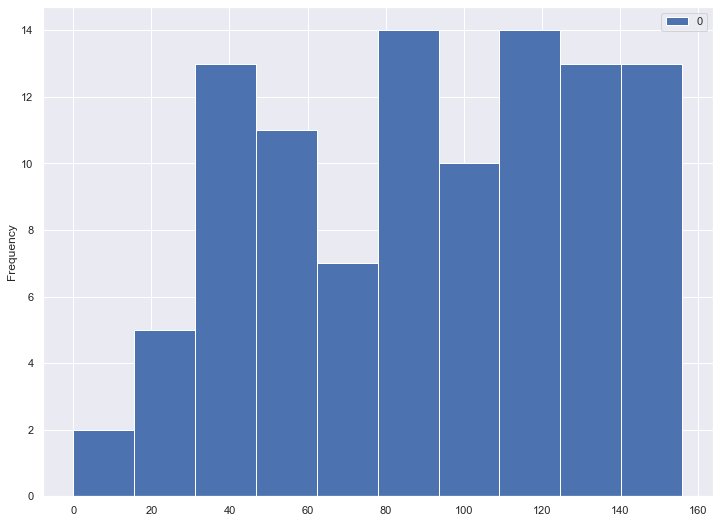

In [121]:
pd.DataFrame(islands).plot.hist()

The distributions of the populations of the islands varies considerably. This will not be an easy prior to select. Here, we should go with the random distribution. 

Choosing Random Distribution is Prior. 

### Solving Problem Through Conventional Means First

### Creating Function to Generate Probabilities for King's Visit

In [92]:
def visitprob(islandpopulations):
    prob = []
    for i in range(len(islandpopulations)):
        if islands[i]!=0:
            if islandpopulations[i+1]>islandpopulations[i]:
                prob.append(1)
            else:
                newprob = (islandpopulations[i+1])/islandpopulations[i]
                prob.append(newprob)
        else:
            prob.append(0)
    return prob

In [93]:
prob = visitprob(islands)

In [94]:
isleprob = pd.DataFrame()

In [95]:
isleprob['Island Population'] = islands

In [96]:
isleprob['probability'] = prob

In [97]:
isleprob.set_index('Island Population')

,probability
Island Population,
0,0.000000
58,1.000000
121,0.305785
37,1.000000
142,0.457746
...,...
30,1.000000
100,0.860000
86,1.000000


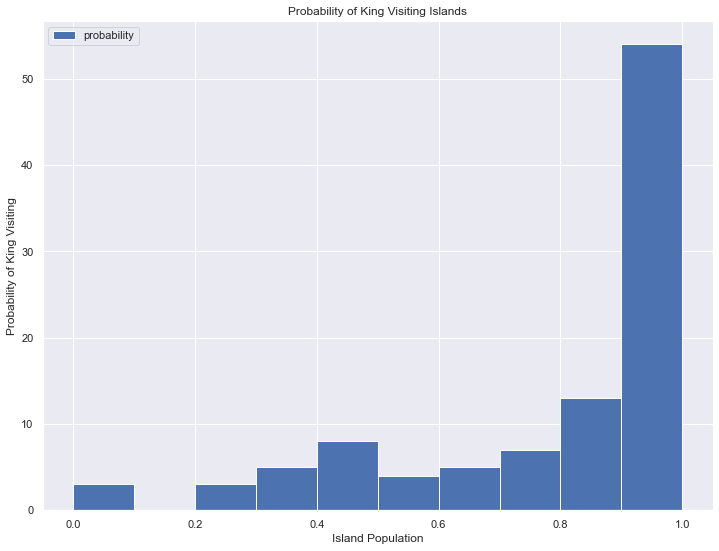

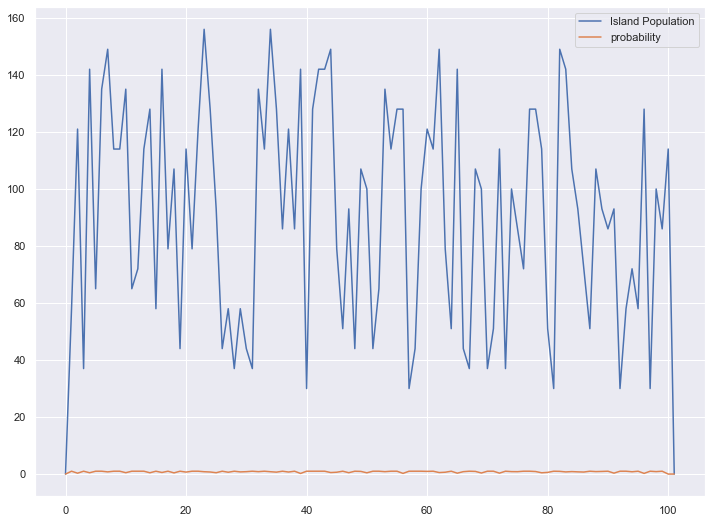

In [111]:
isleprob.plot.hist(x = 'Island Population', y = 'probability')
plt.xlabel('Island Population')
plt.ylabel('Probability of King Visiting')
plt.title("Probability of King Visiting Islands")
isleprob.plot()
plt.show()

Clearly a very skewed distribution, which is to be expected by the parameters set. 

No matter how many times we repeat this process, the outcome is roughly the same. 

The distribution of probabilities mirrors a reversed exponential distribution, or a reverse exponential distribution. 

Choosing Likelihood as reverse exponential.

In [184]:
x = np.linspace(expon.ppf(0.99),

                expon.ppf(0.01), 100)
rv = expon()
dist = rv.pdf(x)
dist = pd.DataFrame(dist)

<AxesSubplot:>

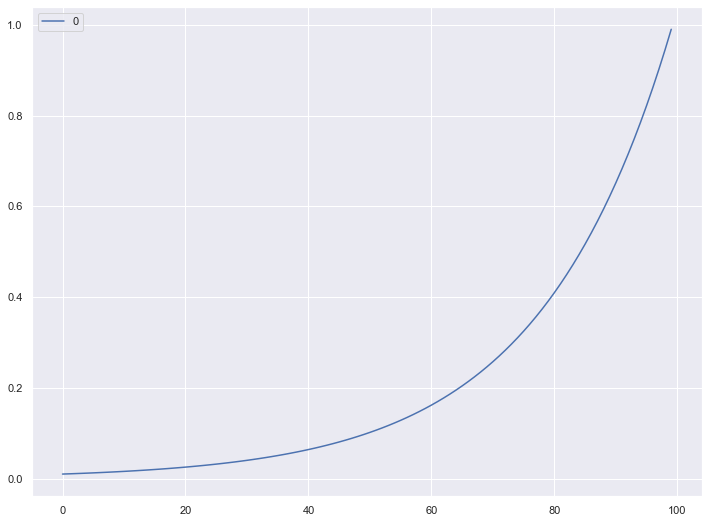

In [100]:
dist.plot()

### Solving Problem Through Monte Carlo Approximation-Markov Chain Method

Creating a function to estimate the probabilities of hopping from one island to the next.

In [115]:
def hopping(islandpopulations, beginning = 1, islandsiter = 800):
    start = beginning
    present = islandpopulations[start]
    #creating an array of probabilities initialized at 0
    probs = np.zeros(islandsiter+1,dtype = 'int')
    probs[0] = start
    for i in range(islandsiter):
        #generating probabilities from distribution between 1 and 0
        newprobs = expon.pdf(random.randrange(4)) #using exponential as likelihood
        nextstart = start + newprobs
        nextpresent = islandpopulations[int(nextstart)]
        p = min(1, nextpresent/present)
        if np.random.random()<p:
            start = nextstart
            present = nextpresent
        probs[i+1] = start
    return probs

In [116]:
sampleprobs = hopping(islands, beginning = 1, islandsiter = 800)
sampleprobs

array([  1,   2,   2,   2,   2,   2,   2,   2,   2,   3,   3,   3,   3,
         4,   4,   4,   5,   5,   6,   6,   6,   6,   6,   6,   7,   7,
         7,   7,   7,   7,   7,   7,   7,   7,   8,   9,   9,  10,  11,
        11,  11,  11,  11,  12,  13,  13,  13,  14,  14,  15,  16,  16,
        16,  16,  16,  16,  16,  16,  17,  18,  18,  18,  18,  18,  18,
        18,  19,  19,  19,  19,  19,  20,  20,  21,  22,  23,  23,  24,
        24,  24,  24,  24,  24,  24,  25,  25,  25,  25,  25,  26,  26,
        26,  26,  27,  27,  27,  27,  27,  28,  29,  29,  29,  29,  30,
        30,  30,  30,  30,  30,  31,  31,  31,  31,  32,  32,  32,  32,
        32,  33,  34,  35,  35,  35,  35,  35,  36,  36,  36,  37,  38,
        38,  38,  38,  38,  38,  38,  38,  38,  39,  39,  39,  39,  39,
        39,  39,  39,  39,  39,  40,  41,  42,  43,  43,  43,  43,  43,
        44,  45,  45,  45,  45,  45,  45,  45,  46,  46,  47,  47,  47,
        47,  48,  48,  48,  48,  48,  49,  49,  49,  49,  49,  4

In [117]:
data = np.bincount(islands[1:-1])
data = data/data.sum()
sb.set(rc={'figure.figsize':(12,9)})

### True Population Distributions

<AxesSubplot:>

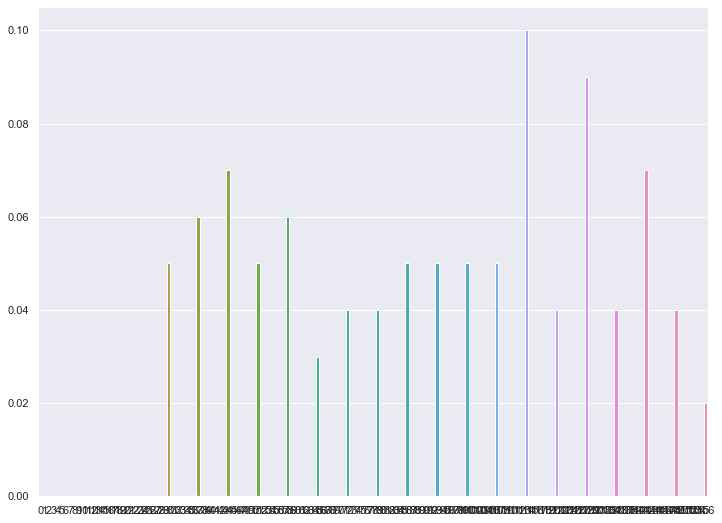

In [118]:
sb.barplot(x = np.arange(len(data)), y = data)

### Estimated Population Proportions

<AxesSubplot:>

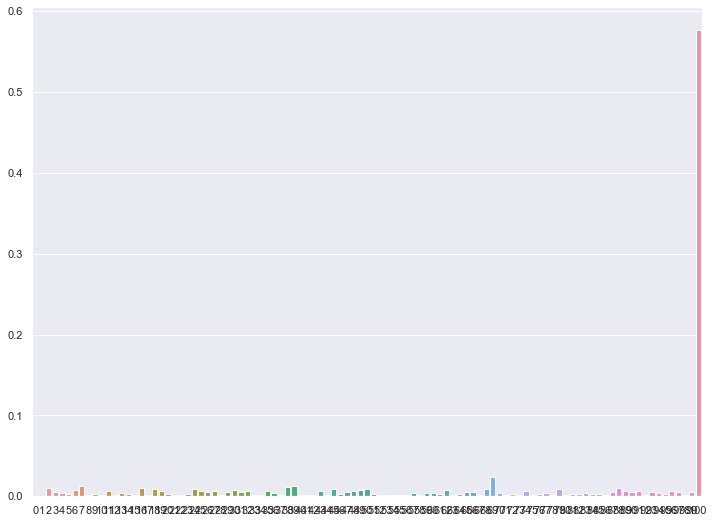

In [119]:
newdata = np.bincount(sampleprobs[1:])
newdata = newdata/newdata.sum()
sb.barplot(x = np.arange(len(newdata)), y=newdata)

### Observation

The estimated population distribution mirrors the distribution which was derived through conventional means.

### Using Metropolis Scheme

In [107]:
def metropolis(beginning, target, proposal, islandsiter, burnin):
    present = beginning 
    future = [present] 
    for i in range(islandsiter):
        proposed = proposal(present)
        p = min(target(proposed)/target(present),1)
        if np.random.random()<p:
            present = proposed
        future.append(present)
    return future[burnin:]

<AxesSubplot:>

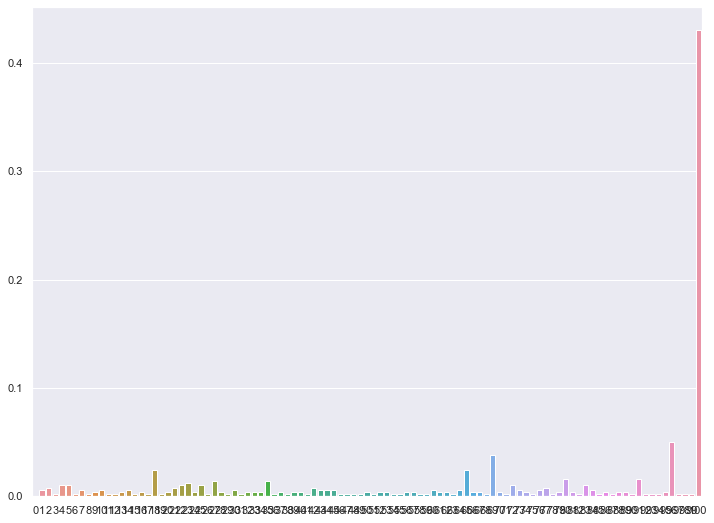

In [108]:
target = lambda x: islands[x] #which island to visit
proposal = lambda x: x + int(np.random.choice([0,1])) #probability of 
#visiting the island
burnin = 0 #burnin period
islandnew = metropolis(1,target,proposal,500,0)
newdata = np.bincount(islandnew[1:])
newdata = newdata/newdata.sum()
sb.barplot(x = np.arange(len(newdata)), y=newdata)

It's pretty clear now that the correct distribution is probably reverse exponential.

However, we can still use Bayesian methods to come up with a more apt probability distribution

In [143]:
sigma = np.std(islands)

In [168]:
stats.norm.pdf(2,1)

0.24197072451914337

In [183]:
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pdf(h)*prior.pdf(theta)

n = 100
h = 100
lik = expon
prior = stats.uniform
sigma = np.std(islands)
naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta
for i in range(niters):
    theta_p = theta + stats.norm(0, sigma).rvs()
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)//2
print("Efficiency = ", naccept/niters)
print("nmcmc = ", nmcmc)

Efficiency =  0.002
nmcmc =  5000


#### Ordinary Least Squares Method

In [109]:
def OLS(dataset):
    feature = str(input('What is the column you want to select as X?'))
    label = str(input('What is the column you want to select as Y?'))
    X = dataset[feature]
    Y = dataset[label]
    X = X.tolist()
    Y = Y.tolist()
    plt.scatter(X,Y)
    X = sm.add_constant(X, prepend = True, has_constant = 'skip')
    result = sm.OLS(Y,X).fit()
    print(result.summary())
    max1 = dataset[feature].max()
    min1 = dataset[feature].min()
    X = np.arange(min1,max1,1)
    l = float(input('Type in the x1 coefficient value from the results summary.\n'))
    m = float(input("Type in the constant value from the results summary.\n"))
    Y = l*X - m
    plt.plot(Y, 'r')
    plt.show()

What is the column you want to select as X?Island Population
What is the column you want to select as Y?probability
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     5.778
Date:                Sun, 05 Dec 2021   Prob (F-statistic):             0.0181
Time:                        22:40:24   Log-Likelihood:                -8.4531
No. Observations:                 102   AIC:                             20.91
Df Residuals:                     100   BIC:                             26.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

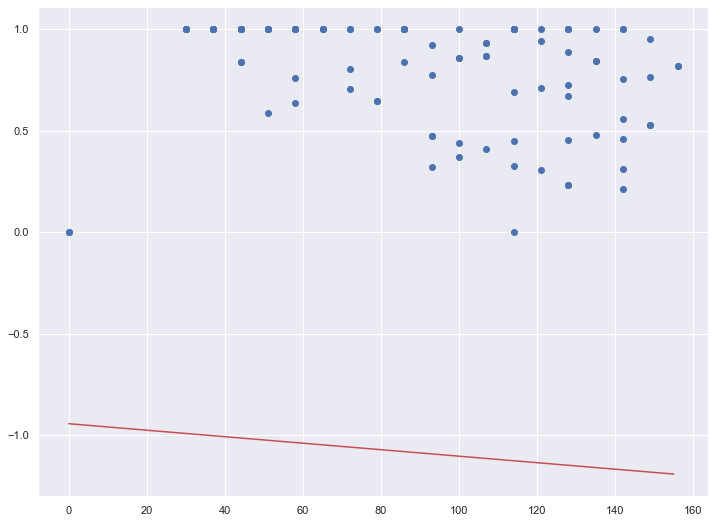

In [110]:
OLS(isleprob)

The choice of the prior and likelihood distributions is still flawed which is why the MCMC methods are giving very low accuracy results. However, the plotted distributions are matching with the true and estimated distributions. 

Further research is required into this. 